In [2]:
import time
import tensorflow.keras.backend as K
K.clear_session()

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler

import keras
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical

from keras.callbacks import ReduceLROnPlateau


%matplotlib inline

%run cnn_wavelet.ipynb import SeRe

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.metrics import Precision, Recall



Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ wavelet_layer_transformation    │ (None, 28, 28, 1)      │             0 │
│ (WaveletLayerTransformation)    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        12,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 234,980 (917.89 KB)

 Trainable params: 234,980 (917.89 KB)

 Non-trainable params: 0 (0.00 B)

In [3]:
%pip install -q tensorflow kaggle kagglehub

You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import kagglehub
import os

# Download latest version
data_dir = kagglehub.dataset_download("gpiosenka/sports-classification")

print(os.listdir(data_dir))
print("Path to dataset files:", data_dir)

/Users/rondineli/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['valid', 'test', 'EfficientNetB0-100-(224 X 224)- 98.40.h5', 'sports.csv', 'train']
Path to dataset files: /Users/rondineli/.cache/kagglehub/datasets/gpiosenka/sports-classification/versions/9


In [5]:
import time
import os
import tensorflow.keras.backend as K
K.clear_session()

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping

from tensorflow.keras.metrics import Precision, Recall

import keras
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
%run cnn_se_res.ipynb import SeResNet
WITH_SGD = False
IMG_SIZE = (32, 32)  # Resize images
BATCH_SIZE = 16

# cleaning previously sessions
K.clear_session()

# List categories (folders)
categories = os.listdir(data_dir)
num_classes = len(os.listdir(f"{data_dir}/train"))
print(f"Number of classes: {num_classes}")
print("Sports categories:", categories)

# 100 classes input
train_dir = f"{data_dir}/train"  
test_dir = f"{data_dir}/test"

train_datagen = ImageDataGenerator(
    rescale=1./255,         # Normalize pixel values to [0, 1]
    rotation_range=40,      # Rotate images on up to 40 degrees
    width_shift_range=0.2,  # change images horizontally (20% of width)
    height_shift_range=0.2, # Change images vertically (20% of height)
    zoom_range=0.2,         # zoom images by up to 20%
    brightness_range=[0.6, 1.4], 
    fill_mode="nearest" # Fill in missing pixels after transformations
)

# Use a simpler generator for test data
# (no augmentation, only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Define batch generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

# Define batch generators for test
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

train_classes = len(os.listdir(train_dir))
test_classes = len(os.listdir(test_dir))

# should have 100 classes
assert train_classes == 100
assert test_classes == 100
print(f"Train classes: {train_classes}, Test classes: {test_classes}")


# Initialize SeResNEt model (controller main initiated)
model = SeResNet().main()


'''
Callback Early stop based on val_accuracy
based on the amount of epochs before stpoing when no improvement
this will keep the model balanced to avoid overfiting
'''

class CustomEarlyStopping(EarlyStopping):
    def on_train_end(self, logs=None):
        print("\n🚀 Training stopped early due to no improvement in validation accuracy!")


early_stopping = CustomEarlyStopping(
    monitor='val_accuracy',  
    patience=10,
    restore_best_weights=True
)

'''
CallBack to stop loss based on the amount of
epochs to avoid underfit of the model
'''
lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss", factor=0.3, patience=4, min_lr=1e-1
)

'''
Callback to stop and reduce learning hate in half
as patience=3, will wait in 3 epochs before improvements to reduce learning rate
'''
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

optimizer = Adam(learning_rate=0.00005, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

# If SGD is true, then test with SGD instead
if WITH_SGD:
    optimizer = SGD(learning_rate=0.0001, momentum=0.9)

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

# Train the model
print(f'Running fit/history for {model.name}')
start_time = time.time()
hist = model.fit(
    train_generator,
    epochs=300,
    validation_data=test_generator,
    callbacks=[lr_scheduler, reduce_lr, early_stopping]
)
elapsed_time = time.time() - start_time

histories = {
    'name': model.name,
    'hist': hist,
    'elapsed_time': elapsed_time
}


mkdir: /Users/rondineli/.kaggle: File exists
cp: kaggle.json: No such file or directory
chmod: /Users/rondineli/.kaggle/kaggle.json: No such file or directory
Traceback (most recent call last):
  File "/Users/rondineli/Library/Python/3.9/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/Users/rondineli/Library/Python/3.9/lib/python/site-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/Users/rondineli/Library/Python/3.9/lib/python/site-packages/kaggle/api/kaggle_api_extended.py", line 407, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /Users/rondineli/.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/
Number of classes: 100
Sports categories: ['valid', 'test', 'EfficientNetB0-100-(224 X 224)- 98.40.h5', 'sports.csv', 'train']
Found 13492 images belonging to 100 classes.
Found 500 i

name


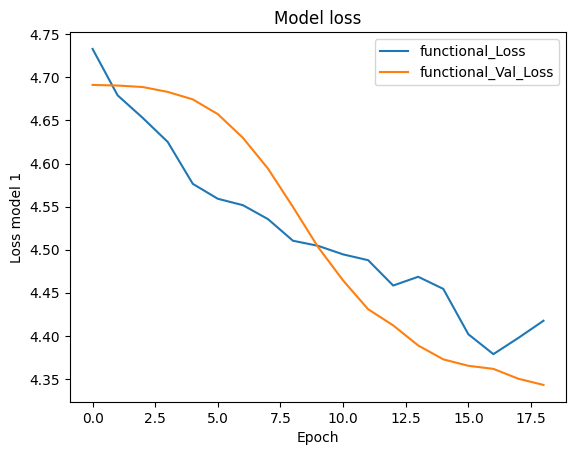

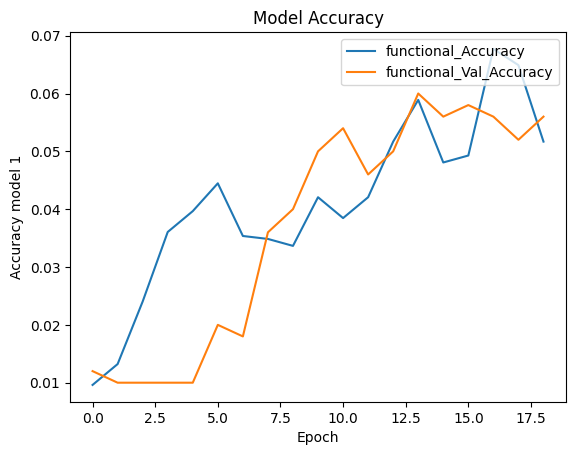

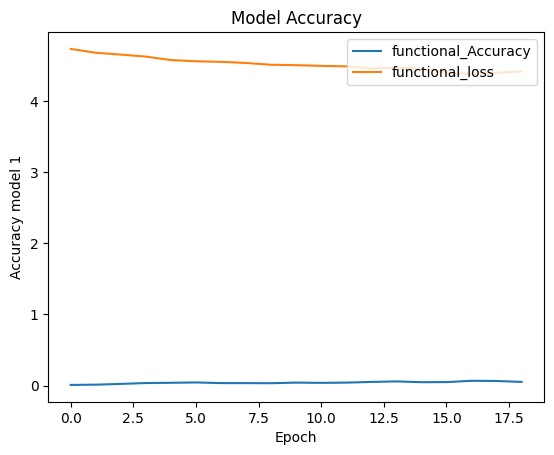

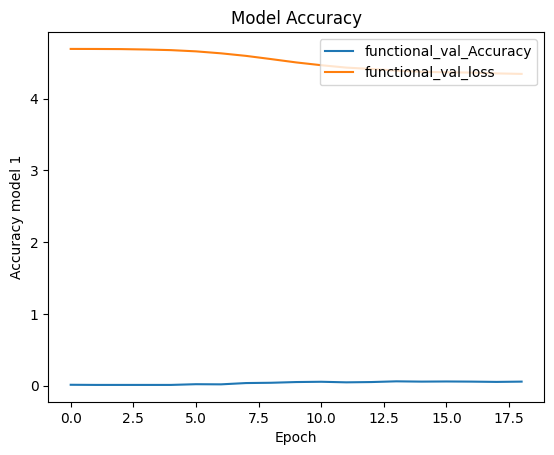

In [23]:
import matplotlib.pyplot as plt

leg = []

print(h)
leg.append(f'{histories["name"]}_Loss')
leg.append(f'{histories["name"]}_Val_Loss')
plt.plot(histories['hist'].history['loss'])
plt.plot(histories['hist'].history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss model 1')
plt.xlabel('Epoch')

plt.legend(leg, loc='upper right')
plt.savefig("400_epochs_se_res_loss.png", dpi=300)
plt.show()


#import matplotlib.pyplot as plt
#plt.plot(hist.history['accuracy'])
#plt.plot(hist.history['val_accuracy'])
#plt.title(f'Model Accuracy')
#plt.ylabel('Accuracy')
#plt.xlabel('Epoch')
#plt.legend(['Train', 'Val'], loc='upper right')
#plt.show()


leg = []
import matplotlib.pyplot as plt

leg.append(f'{histories["name"]}_Accuracy')
leg.append(f'{histories["name"]}_Val_Accuracy')
plt.plot(histories['hist'].history['accuracy'])
plt.plot(histories['hist'].history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy model 1')
plt.xlabel('Epoch')

plt.legend(leg, loc='upper right')
plt.savefig("400_epochs_se_res__accuracy.png", dpi=300)
plt.show()

leg = []
import matplotlib.pyplot as plt

leg.append(f'{histories["name"]}_Accuracy')
leg.append(f'{histories["name"]}_loss')
plt.plot(histories['hist'].history['accuracy'])
plt.plot(histories['hist'].history['loss'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy model 1')
plt.xlabel('Epoch')
plt.legend(leg, loc='upper right')
plt.savefig("400_epochs_se_res__loss.png", dpi=300)
plt.show()

leg = []
import matplotlib.pyplot as plt

leg.append(f'{histories["name"]}_val_Accuracy')
leg.append(f'{histories["name"]}_val_loss')
plt.plot(histories['hist'].history['val_accuracy'])
plt.plot(histories['hist'].history['val_loss'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy model 1')
plt.xlabel('Epoch')
plt.legend(leg, loc='upper right')
plt.savefig("400_epochs_se_res__loss_acc.png", dpi=300)
plt.show()


In [17]:
print(f"Acc: {histories['hist'].history['accuracy']}")
print(f"Val_Acc: {histories['hist'].history['val_accuracy']}")

train_acc = histories['hist'].history['accuracy']
val_acc = histories['hist'].history['val_accuracy']

train_improvement = ((train_acc[-1] - train_acc[0]) / train_acc[0]) * 100
val_improvement = ((val_acc[-1] - val_acc[0]) / val_acc[0]) * 100

print(f"[{histories['name']}] Training Accuracy Improvement: {train_improvement:.2f}%")
print(f"[{histories['name']}] Validation Accuracy Improvement: {val_improvement:.2f}%")

Acc: [0.006009615492075682, 0.015625, 0.018028846010565758, 0.02764423005282879, 0.03846153989434242, 0.02764423005282879, 0.03125, 0.04878048598766327, 0.05288461595773697, 0.05528846010565758, 0.045673076063394547, 0.048076923936605453, 0.04927884787321091, 0.045673076063394547, 0.07572115212678909, 0.05889423191547394, 0.0416666679084301, 0.07331730425357819, 0.06490384787321091, 0.07692307978868484, 0.07331730425357819, 0.07804878056049347, 0.08052884787321091, 0.08533653616905212, 0.07211538404226303, 0.06610576808452606, 0.09134615212678909, 0.078125, 0.07692307978868484, 0.08173076808452606]
Val_Acc: [0.009999999776482582, 0.009999999776482582, 0.014000000432133675, 0.009999999776482582, 0.014000000432133675, 0.017999999225139618, 0.017999999225139618, 0.035999998450279236, 0.04399999976158142, 0.05000000074505806, 0.05000000074505806, 0.06800000369548798, 0.07000000029802322, 0.07199999690055847, 0.07000000029802322, 0.07800000160932541, 0.07400000095367432, 0.06800000369548798

In [18]:
histories[0]['hist']['history'].__dict__


KeyError: 0